# Optimizing array layout for all-sky radio telescopes using the condition number of the telescope operator

by Tim Molteno (tim@elec.ac.nz)

The discrete sky telescope operator [1] is a linear measurement operator that maps sky-vectors to visibility measurements. This works for arbitrary fields of view, non-coplanar baselines and non-flat skies.

Here we use the condition number of the Moore-Penrose inverse of the telescope operator as an optimization criterion for choosing antenna array layouts.


## Theory

The Moore-Penrose inverse,  $A^+$, (or pseudoinverse) of the telescope operator $A$, maps visibilities to sky-vectors. It can be interpreted as providing the solution, $s$, to the inverse problem $v = A s$, with minimum euclidian norm. Using the SVD of A we can write

$ A = U \Sigma V^H $
or
$ A^H = V \Sigma^H U^H $

and so
$ y = A x = U \Sigma V^H x $
which means:
$ V \Sigma^H U^H y = V \Sigma^H U^H U \Sigma V^H x $, and so

$ V \Sigma^H U^H y = V \Sigma^H \Sigma V^H x $

$A^+ = V \Sigma^+ U^\star$
The condition number of $A^+$ is the ratio between the largest and smallest (non-zero) singular value.

Using the pseudoinverse and a matrix norm, one can define a condition number for any matrix:

\[ cond ( A ) = ‖ A ‖ ‖ A + ‖  \]

A large condition number implies that the problem of finding least-squares solutions to the corresponding system of linear equations is ill-conditioned in the sense that small errors in the entries of A {\displaystyle A} A can lead to huge errors in the entries of the solution.[27] 


The condition number is the radio of the largest to the smallest singular values of the matrix.

 $cond(A) = \frac{\sigma_0}{\sigma_n} $

### Condition number and uncertainty

The point here is to optimize the telescope operator to minimize the posterior variance when a sky is inferred from some observations. In the discrete operator case, we can make statements about how a gaussian prior sky is inferred by Bayes' rule into a posterior sky [cite the paper]

The ideal telescope operator inversion would maximally reduce the entropy of the posterior sky. In other words, the variance of the posterior would be minimized.

In the natural basis, the telescope operator is invertible, and in this basis, the posterior variance can be computed from $A^{-1}$. 

The entropy of the posterior is
$\ln(\det ( 2 \pi e \Sigma ))$

Where the SVD gives us the determinant as the product of the singular values of a matrix.

## Gradient Descent optimization

Recent work on calculating the gradient of the SVD of a matrix [cite tensorflow stuff]
means that gradient descent algorithms can be applied to optimize the condition number
as a function of the antenna positions. Automatic differentiation can be applied to compute the gradients 

 $ \frac{d K(A)}{d x_i} $
 
 of the condition number, $K(A)$ with respect to the antenna positions $x_i$. The optimization of $K(A)$ can be done using stochastic gradient descent, and carried out using standard machine-learning frameworks.
 
 
 ## All-sky Y-array example
 
 COnsider a three-branch 'Y' antenna array consisting of branches equally spaced around the circle, each with $N$ antennas per branch. The $3N$ distances $x_i$ of of the $i$th antenna from the center of the array for m the optimization variables in this problem.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Testing the constraining of inputs

The inputs to the optimization function must not allow negative positions along the arms (otherwise the array effectively has six arms). To ensure this we pass the list of radius values through a function that maps all values to positive numbers.

This function must be differentiable so that the gradient of the condition number can be determined.

In [2]:
x = np.linspace(-2,10,100)

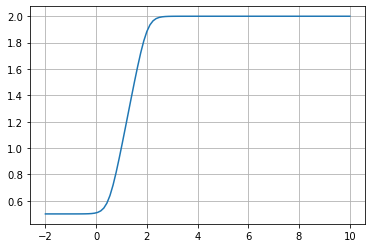

In [3]:
def constrain(x, lower, upper, sharpness=6):
    clip_lower = tf.math.softplus((x-lower)*sharpness)/sharpness + lower
    return upper - tf.math.softplus((-clip_lower + upper)*sharpness)/sharpness

y = constrain(x,0.5,2)
plt.plot(x,y.numpy())
plt.grid(True)

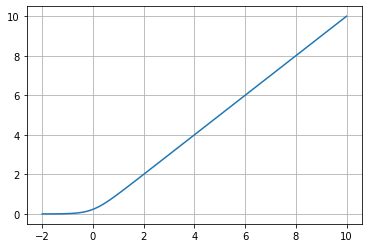

In [4]:
sharpness = 3
y = tf.math.softplus(x*sharpness)/sharpness
plt.plot(x,y.numpy())
plt.grid(True)

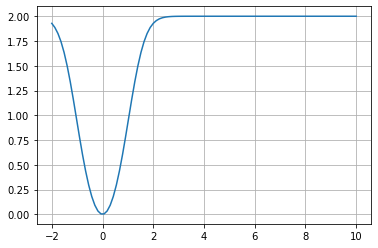

In [5]:
y = (tf.math.sigmoid(x**2)-0.5)*4
plt.plot(x,y.numpy())
plt.grid(True)

Both of these functions do pretty well at mapping all values to between 0..2.  I'll use the softmax version.

## Penalizing antennas that are close together

We need a differentiable function that is nonzero when an antenna pair is closer than some threshold.

In [6]:
def penalize(duv2, limit=0.2):
    sharpness = 50
    duv = tf.sqrt(duv2)
    clip_lower = tf.math.softplus((limit - duv)*sharpness)/sharpness
    return (clip_lower/limit)**2

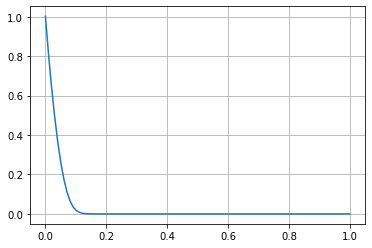

In [7]:
du = np.linspace(0,1,100)
plt.plot(du, penalize(du**2, limit=0.1))
plt.grid(True)

## Optimization Strategy

Tensorflow has recently included the derivative of the SVD operator, so we can compute the gradient of the antenna positions with respect to the condition number!. This is shit hot, and opens up standard optimization strategies to  find optimum array layouts.

### Cost Function

Penalize antennas too close together? 

### Starting Layout

Currently random, but may make sense to start with a perturbed uniform.

## Results

The advantage of using condition number as an optimization criterion is that it provides a quantitative measure of the quality of the inversion that is possible when imaging from the array.

### Choice of Optimizer

We use tensorflow which allows the use of stochastic gradient minimizers that can auto-differentiate the SVD operation. The source code for this strategy is in github [https://github.com/tmolteno/TART-3/tree/master/array/disko_array_opt].

In [8]:
import json
with open('best.json', 'r') as f:
    results = json.load(f)

results['condition_number']

2.732922487603638

In [9]:
import array_opt
ant = array_opt.YAntennaArray.from_json('best.json')

INFO: nside=1 res=3517.9380857010237 arcmin
INFO: nside=2 res=1758.9690428505119 arcmin
INFO: nside=4 res=879.4845214252559 arcmin
INFO: nside=8 res=439.74226071262797 arcmin
INFO: nside=16 res=219.87113035631398 arcmin
INFO: nside=32 res=109.93556517815699 arcmin
INFO: New SubSphere, nside=32
INFO: New SubSphere, nside=32. npix=5056


Text(0.5, 1.0, 'Optimized antenna layout')

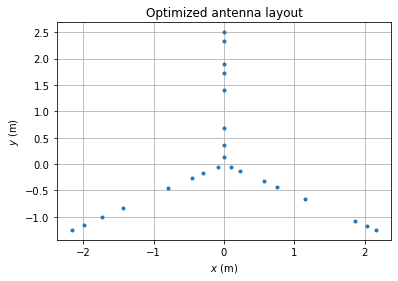

In [10]:
ant_pos = ant.get_ant_pos(ant.arms)
plt.plot(ant_pos[:,0], ant_pos[:,1], '.')
plt.grid(True)
plt.xlabel("$x$ (m)")
plt.ylabel("$y$ (m)")
plt.title('Optimized antenna layout')

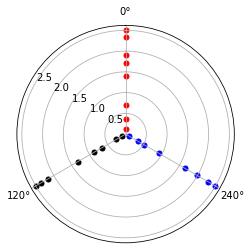

In [11]:
theta = np.zeros_like(ant.arms[0])
angles = (0, 120, 240)
r = ant.arms[0]
area = 25
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.set_thetagrids(angles)
ax.set_rlabel_position(60)
ax.set_theta_zero_location("N")
c0 = ax.scatter(theta, ant.arms[0], c='red', s=area, alpha=1)
c120 = ax.scatter(theta + np.radians(120), ant.arms[1], c='black', s=area, alpha=1)
c240 = ax.scatter(theta + np.radians(240), ant.arms[2], c='blue', s=area, alpha=1)

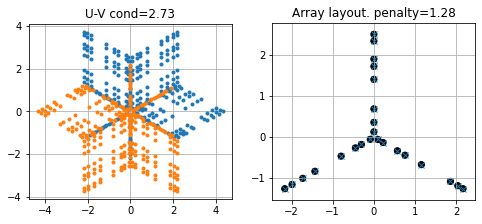

In [12]:
ant.init_plot()
x_opt = array_opt.constrain(ant.x, ant.radius_min, ant.radius)
ant.plot_uv('best.pdf', x_opt,
            results['penalty'],
            results['condition_number'])

## Robustness of solutions

There is a reasonable question about how robust the solutions are to small changes in parameters. This will be tested by considering different potential factors

* Pixelization
* Errors in antenna position

### Pixelization 

Pixelization does not appear to change the optimization function much. Starting at a solution with 5000 pixels, and reducing the resolution so that npix=1248 results in a very similar optimium.

    python3 array_opt.py --iter=10000 --fov=160 --arcmin=360 \
        --radius=2.5 --learning-rate=0.001 \
        --initial best.json
        
Increasing the resolution to 90 arc minutes (or 22000 pixels) produces a similar result.

### Errors in Antenna position

This is tested using random offsets from the optimium array antenna positions. We expect from reference[1] that the effect on inversions of the telescope operator by perturbations of the telescope operator matrix (caused by modifications of the antenna positions) will be bounded above by the condition number, and therefore these solutions will be robust.

A numerical experiment involving adding random offsets to the antenna locations shows that this is the case. Figure, shows a histogram of condition number for solutions of a 24-element Y antenna with an arm-length of 2.5 meters. The antennas are perturbed with a zero-mean gaussian with a standard deviation of 1mm.

In [24]:
n_trials = 1000
try:
    res = np.load('res.npy')
except:
    l, m, n_minus_1, p2j, theta, pixel_areas, radius, radius_min, min_spacing = array_opt.init(radius_lower=0.1, ant=ant)
    res = []
    delta = 1e-3   # 1 mm
    for i in range(n_trials):
        _x, _y, _z = array_opt.get_ant_pos(ant.x)
        _x += np.random.normal(0, delta, _x.shape[0])
        _y += np.random.normal(0, delta, _y.shape[0])
        _z += np.random.normal(0, delta, _z.shape[0])
        penalty, cond = array_opt.global_f(_x, _y, _z, l, m, n_minus_1, p2j, pixel_areas, min_spacing)
        res.append(cond.numpy())
    res = np.array(res)
    np.save('res.npy', res)

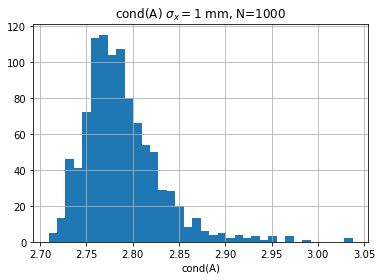

In [25]:
plt.hist(res, bins='fd')
plt.title('cond(A) $\sigma_x=1$ mm, N={}'.format(n_trials))
plt.xlabel('cond(A)')
plt.grid(True)
plt.savefig('cond_histogram.pdf')

In [26]:
n_trials = 1000
try:
    res5 = np.load('res5.npy')
except:
    l, m, n_minus_1, p2j, theta, pixel_areas, radius, radius_min, min_spacing = array_opt.init(radius_lower=0.1, ant=ant)
    res5 = []
    delta = 5e-3   # 1 mm
    for i in range(n_trials):
        _x, _y, _z = array_opt.get_ant_pos(ant.x)
        _x += np.random.normal(0, delta, _x.shape[0])
        _y += np.random.normal(0, delta, _y.shape[0])
        _z += np.random.normal(0, delta, _z.shape[0])
        penalty, cond = array_opt.global_f(_x, _y, _z, l, m, n_minus_1, p2j, pixel_areas, min_spacing)
        res5.append(cond.numpy())
    res5 = np.array(res5)
    np.save('res5.npy', res5)

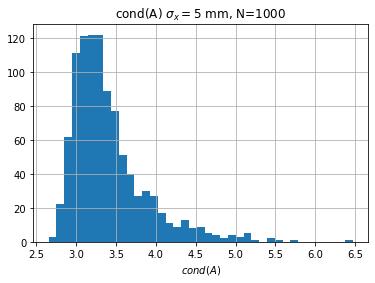

In [29]:
plt.hist(res5, bins='fd')
plt.title('cond(A) $\sigma_x=5$ mm, N={}'.format(n_trials))
plt.xlabel('$cond(A)$')
plt.grid(True)
plt.savefig('cond_histogram5.pdf')

We can conclude that, in this array, if antenna position errors can be kep below 1mm, the condition number of the resulting telescope operator is likely to remain close to the optimal value.

## Comparison with Traditional techniques

Traditionally optimization is based on the PSF of the telescope [Thomson Moran and Swenson] calculated from an inverse FFT of the U-V plane. 

There are two bases for comparison. One is to compute the condition number for a traditional telescope (such as meerkat, or VLA) the other is to evaluate to the solutions found here using these traditional criteria.

### Comparison with the existing TART-2 array

The TART-2 array was designed to minimize the sidelobes in the PSF of the array. This optimization was carried out using four identical tiles that are placed in different orientations to achieve optimal behaviour. 

    TODO. Read JSON file of antenna positions, and construct the u,v,w 

### Evaluation of cond-optimized arrays

While wide field arrays with very large fields of view are 

## References

* http://www.math.bas.bg/infres/MathBalk/MB-15/MB-15-035-048.pdf An excellent overview which includes the use of K(A) to deal with Moore-Penrose inverses.
* In https://stanford.edu/~boyd/papers/pdf/diag_scaling_DR_ADMM.pdf we find the interesting statement. Minimization of the pseudo condition numberλmax/λmin>0can be posed as a convex optimization problem and be solved exactly, see [15, Section 6] which also contains heuristics to reduce the pseudo condition number. Reference 15 is ". Giselsson and S. Boyd.  Metric selection in fast dual forwardbackward splitting.Automatica, 2014." see below
* https://web.stanford.edu/~boyd/papers/pdf/metric_select_fdfbs.pdf 
* Cook, R. Dennis; Forzani, Liliana. On the mean and variance of the generalized inverse of a singular Wishart matrix. Electron. J. Statist. 5 (2011), 146--158. doi:10.1214/11-EJS602. https://projecteuclid.org/euclid.ejs/1300198786
* https://www.jstor.org/stable/2983755?seq=1 This is by Rao, and looks really really good. SImilarly, by Mitra https://doi.org/10.1016/S0169-7161(80)80045-9
* https://github.com/tensorflow/tensorflow/issues/13641 This is the issue where the SVD derivative is really worked through by @refraction-ray (This the missing diagonal imaginary part is definitely not trivial, but has been ignored for a long time until @refraction-ray (Shixin Zhang) mentioned and solved it). Date Sept 2 2019. https://re-ra.xyz/misc/complexsvd.pdf is where the correct formula is derived.
